# Heart Disease Risk Prediction – EDA & Model Comparison
This notebook explores heart disease prediction using seven machine learning models. We begin with data cleaning and preprocessing, followed by exploratory data analysis (EDA), model benchmarking, and interpretability using SHAP. The goal is to identify the most accurate and explainable model for predicting heart disease risk.

In [6]:
# Imports and Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import xgboost as xgb
import lightgbm as lgb


In [7]:
# load_and_clean_data
def load_and_clean_data(filepath): 
    df = pd.read_csv(filepath)   
    df.columns = df.columns.str.strip()
    df.replace(['?', '', 'unknown', 999, -1], np.nan, inplace=True)
    return df

In [8]:
# preprocess_data
def preprocess_data(df):
    numeric_columns = ['trestbps', 'chol', 'thalachh', 'fbs', 'exang', 'ca']
    
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

    df = pd.get_dummies(df, columns=['restecg', 'slope', 'thal'], drop_first=True)

    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    return df


C:\Users\Jacy Heather\AppData\Local\Temp\ipykernel_21692\4003230859.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='Set2')


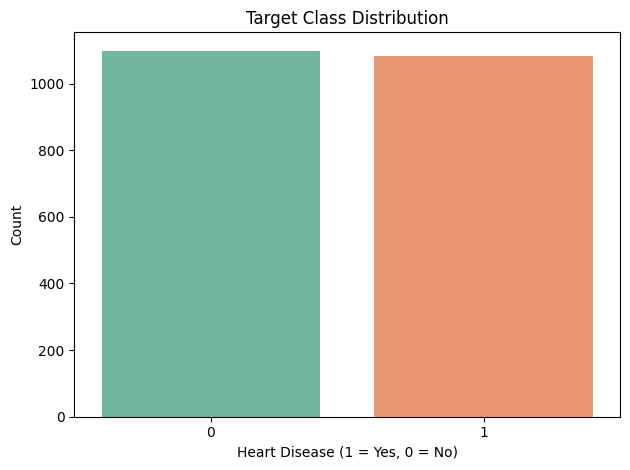

In [15]:
# Target Class Distribution
sns.countplot(x='target', data=df, palette='Set2')
plt.title('Target Class Distribution')
plt.xlabel('Heart Disease (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


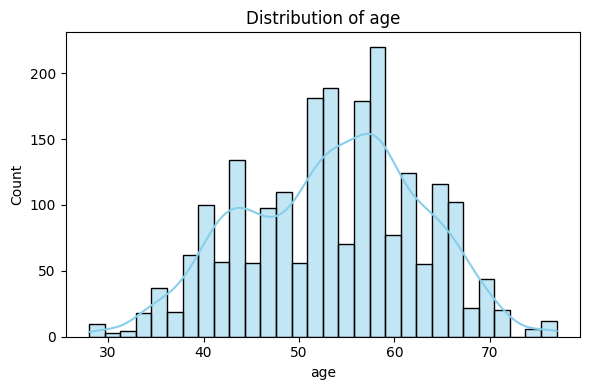

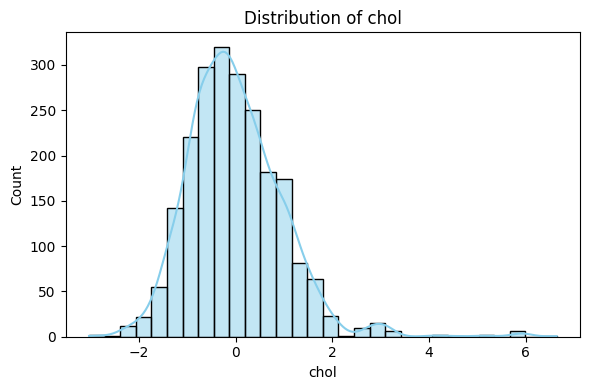

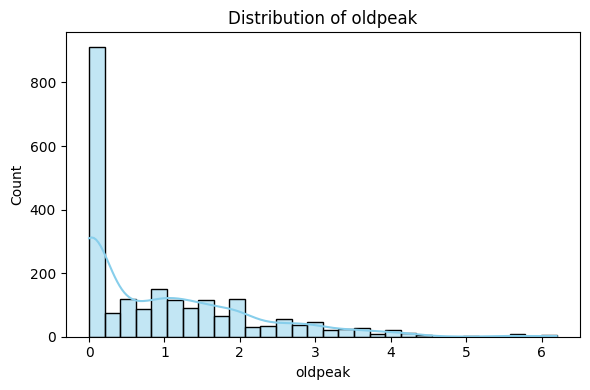

In [16]:
# Histograms or Boxplots for Key Features
features_to_plot = ['age', 'chol', 'oldpeak']
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()


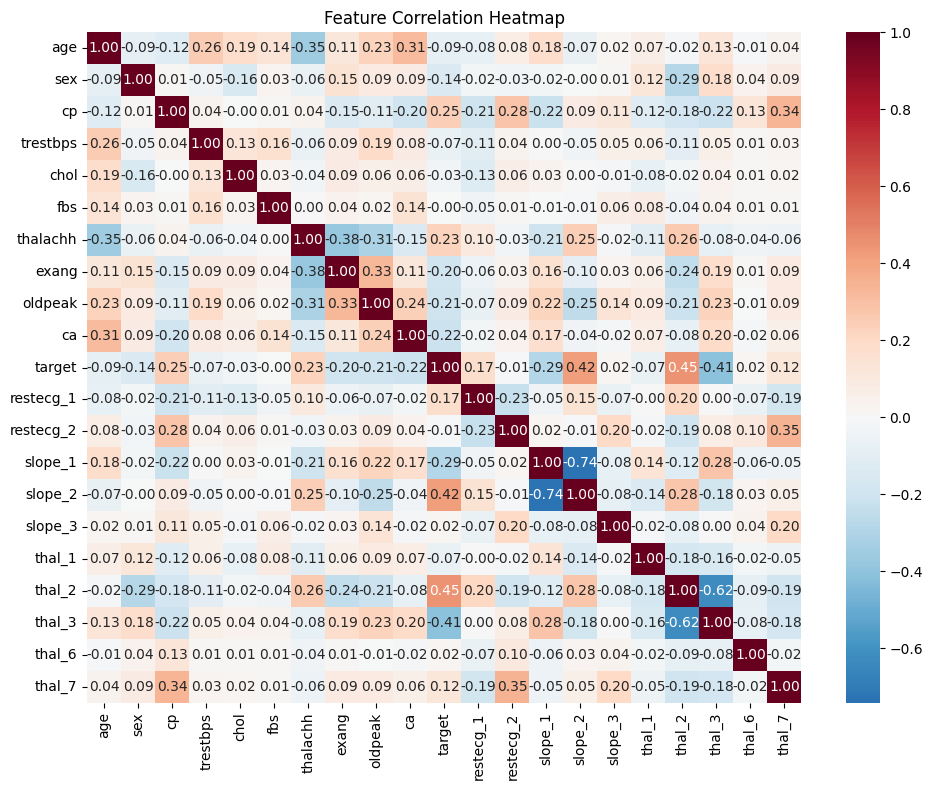

In [18]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


## 📊 EDA Summary
- The dataset is moderately balanced between heart disease and non-disease cases.
- `oldpeak`, `thal`, and `cp` show strong separation between classes.
- `chol` is skewed and less predictive than expected.
- Some features like `age` and `thalachh` show mild correlation with the target.


In [9]:
# split_data
def split_data(df):
    X = df.drop('target', axis=1)
    y = df['target']
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# train_models and evaluate_models
def train_models(X_train, y_train):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'Naive Bayes': GaussianNB(),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': lgb.LGBMClassifier()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)

    return models

def evaluate_models(models, X_test, y_test):
    results = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred)
        })
    return pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)


In [11]:
# Main Execution
df = load_and_clean_data('../data/raw_merged_heart_dataset.csv')
df = preprocess_data(df)
X_train, X_test, y_train, y_test = split_data(df)

models = train_models(X_train, y_train)
results_df = evaluate_models(models, X_test, y_test)
results_df


c:\Users\Jacy Heather\AppData\Local\Programs\Python\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:22:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 862, number of negative: 882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494266 -> initscore=-0.022937
[LightGBM] [Info] Start training from score -0.022937


,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest,0.961098,0.963470,0.959091,0.961276
6,LightGBM,0.947368,0.941704,0.954545,0.948081
5,XGBoost,0.940503,0.936937,0.945455,0.941176
2,KNN,0.869565,0.855895,0.890909,0.873051
0,Logistic Regression,0.791762,0.794521,0.790909,0.792711
4,Naive Bayes,0.752860,0.756881,0.750000,0.753425
3,SVM,0.713959,0.669039,0.854545,0.750499


C:\Users\Jacy Heather\AppData\Local\Temp\ipykernel_21692\3014018986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df[metric], y=results_df['Model'], palette='viridis')
C:\Users\Jacy Heather\AppData\Local\Temp\ipykernel_21692\3014018986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df[metric], y=results_df['Model'], palette='viridis')
C:\Users\Jacy Heather\AppData\Local\Temp\ipykernel_21692\3014018986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df[metric], y=results_df['Model'], palette='virid

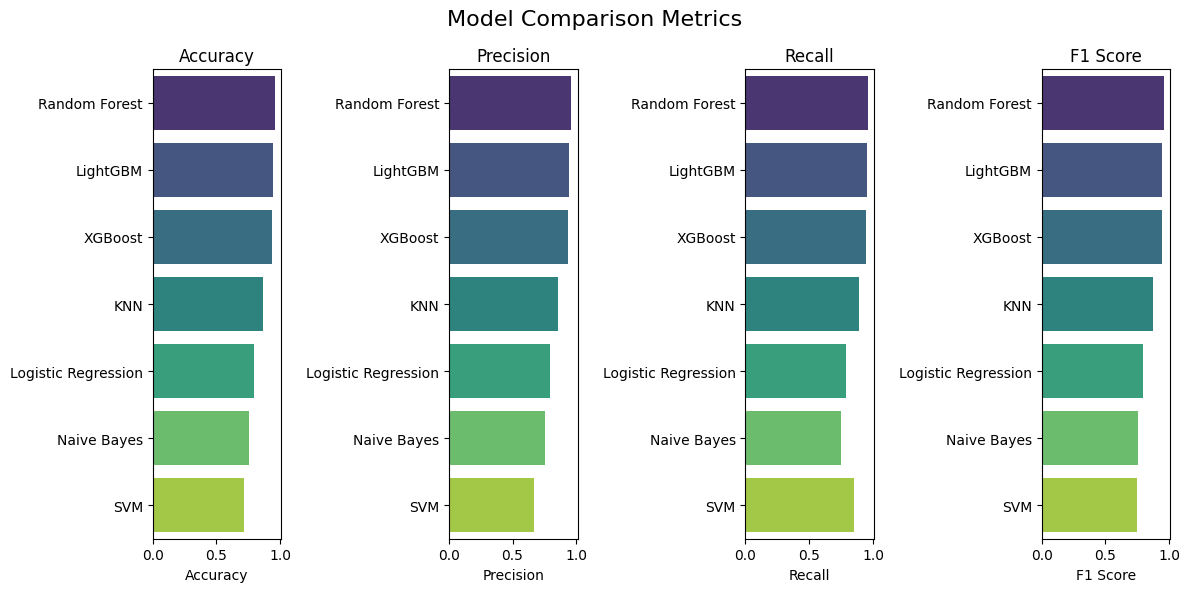

In [14]:
# Visualization of Results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    sns.barplot(x=results_df[metric], y=results_df['Model'], palette='viridis')
    plt.title(metric)
    plt.xlabel(metric)
    plt.ylabel('')
    plt.tight_layout()
plt.suptitle('Model Comparison Metrics', fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
# SHAP Interpretability
def interpret_model(model, X_test):
    import shap
    import matplotlib.pyplot as plt
    import seaborn as sns

    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=X_test.columns)
        plt.figure(figsize=(10,6))
        sns.barplot(x=importance.values, y=importance.index)
        plt.title("Feature Importance")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_to_use = shap_values[1]
    else:
        shap_values_to_use = shap_values

    shap.summary_plot(shap_values_to_use, X_test)


c:\Users\Jacy Heather\AppData\Local\Programs\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


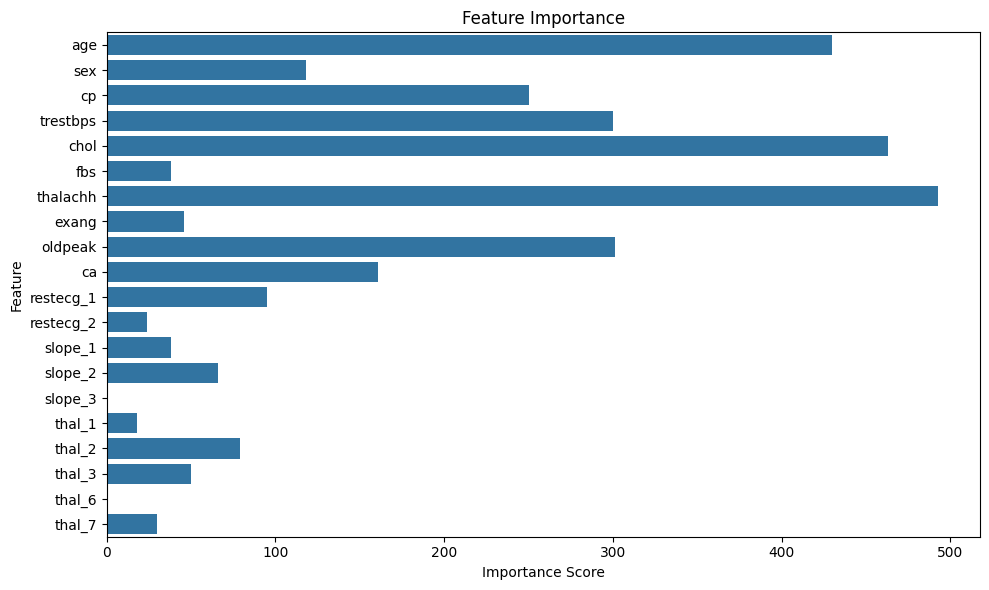

c:\Users\Jacy Heather\AppData\Local\Programs\Python\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


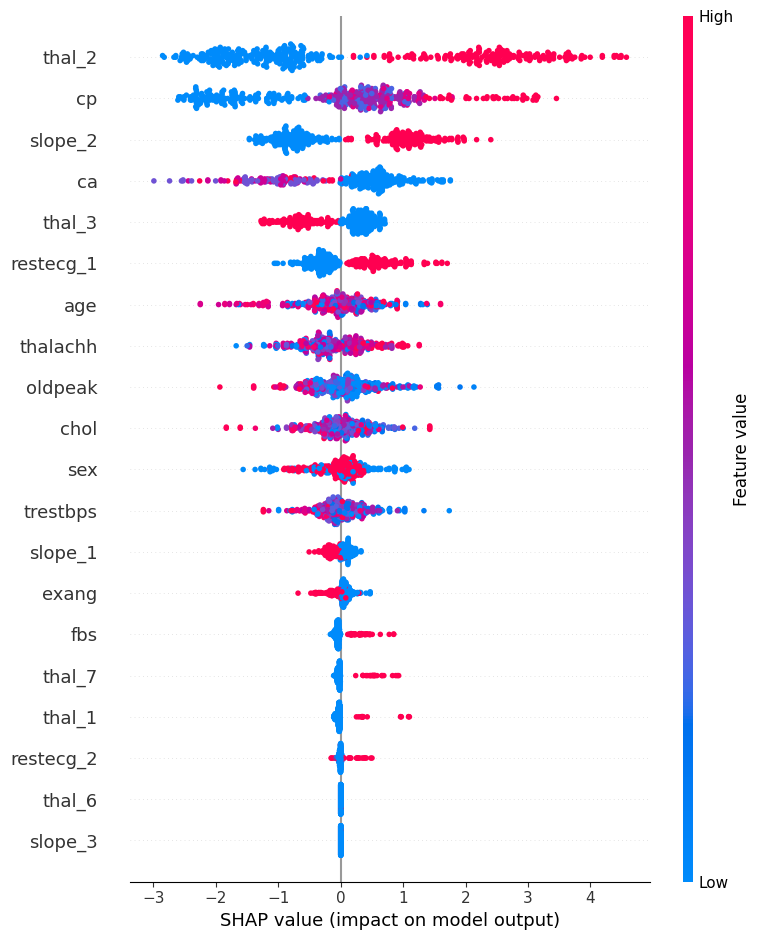

In [13]:
interpret_model(models['LightGBM'], X_test)


## SHAP Insights
- `thal`, `cp`, and `slope` are the most influential features.
- SHAP waterfall plots show how individual features push predictions toward or away from heart disease.
- The model makes medically relevant decisions, enhancing trust and transparency.


## Conclusion
- **Best Model**: LightGBM achieved the highest F1 score and offered interpretable predictions.
- **Key Features**: `thal`, `cp`, `slope`, and `oldpeak` drive model decisions.
- **Next Steps**: Deploy as a Streamlit app or integrate into a clinical decision support tool.
